In [66]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import csv
from gensim.models import Word2Vec
from sklearn.model_selection import ParameterGrid
import time
import pandas as pd


In [60]:
# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora', transform=T.LargestConnectedComponents())
data = dataset[0]

# Convert the PyG data object to a NetworkX graph
G = to_networkx(data, to_undirected=True)
labels = data.y.numpy()

print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')
print(f'Number of classes: {len(set(labels))}')


Number of nodes: 2485
Number of edges: 5069
Number of classes: 7


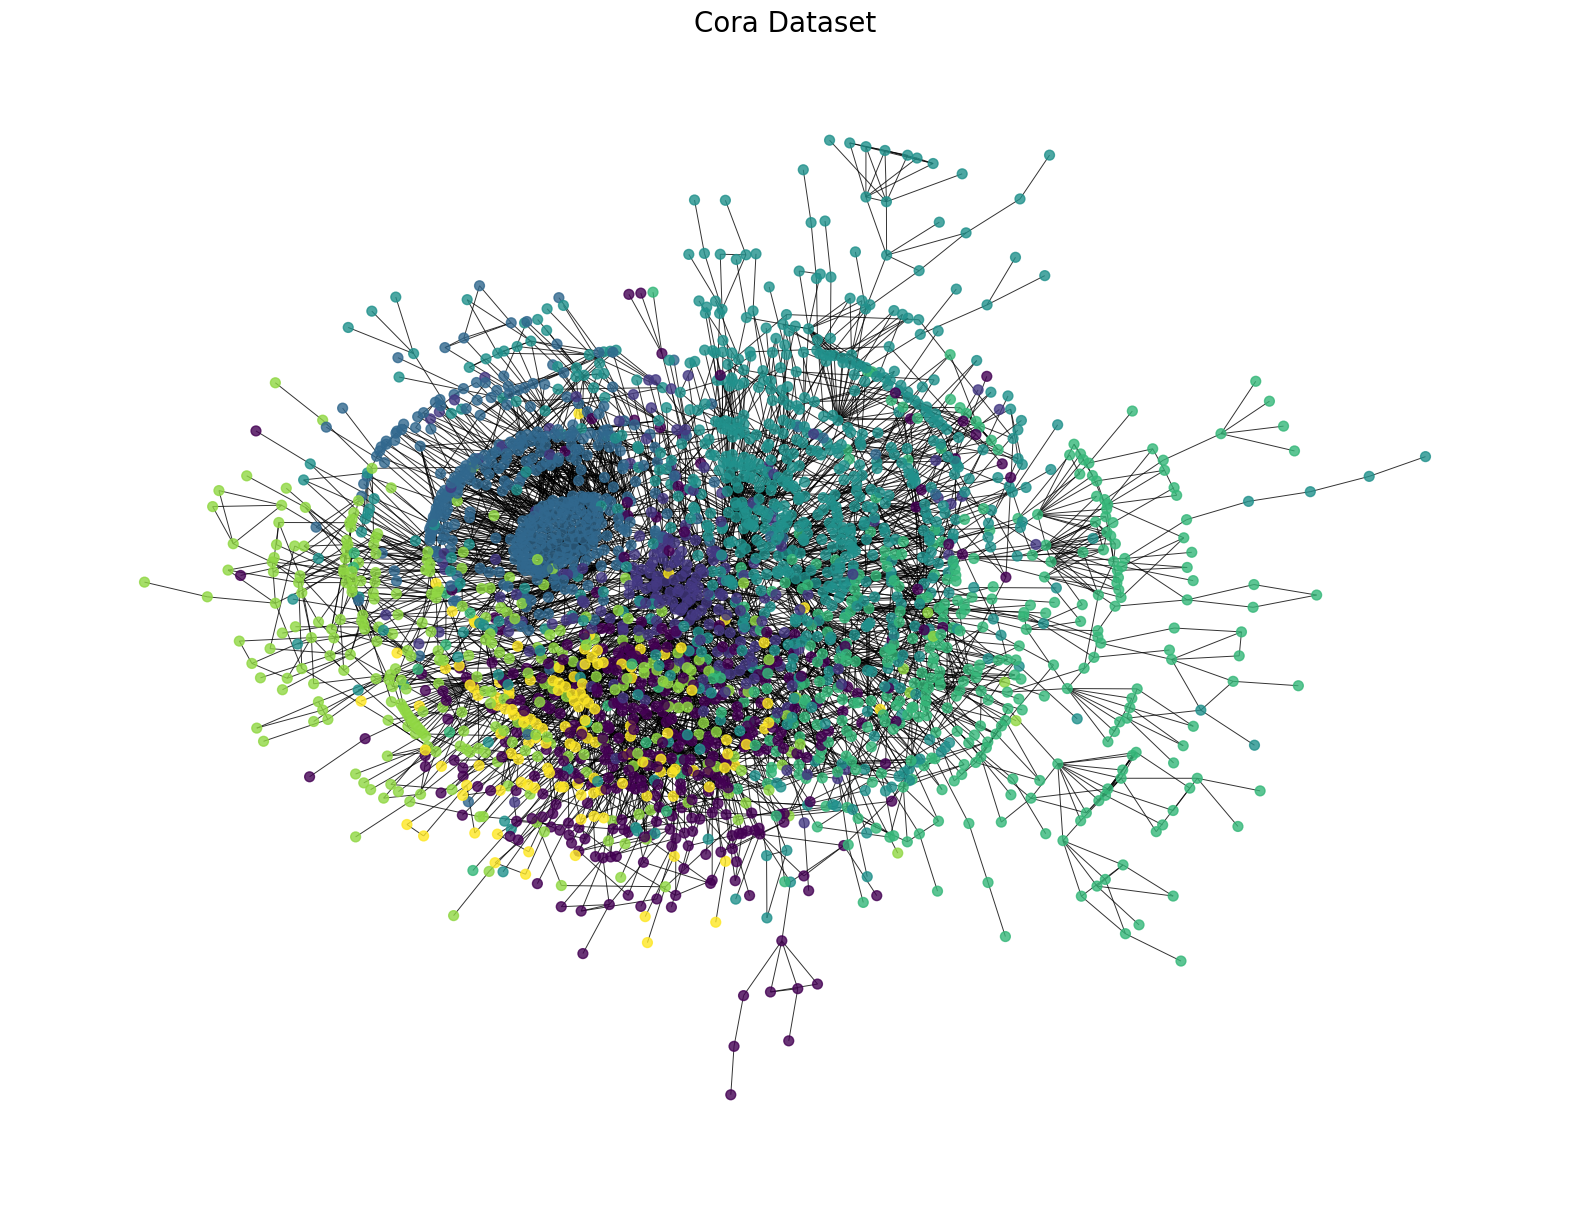

In [7]:
plt.figure(figsize=(20, 15))
plt.title('Cora Dataset', fontsize=20)
pos = nx.kamada_kawai_layout(G)
colors = labels
nx.draw(G, pos=pos, cmap=plt.cm.viridis, node_color=colors, node_size=50, edge_color='black', width=0.7, with_labels=False, node_shape='o', alpha=0.8)
plt.show()



In [61]:

# Función para generar un random walk desde un nodo
def node2vec_random_walk(G, nodo_inicio, walk_length):
    walk = [nodo_inicio] # Se inicializa la caminata con el nodo de inicio
    while len(walk) < walk_length: # El bucle se repite hasta que la caminata alcance walk_length o hasta que el nodo actual no tenga vecinos
        nodo_actual = walk[-1] # Se obtiene el nodo actual
        vecinos = list(G.neighbors(nodo_actual)) # Se obtienen los vecinos del nodo actual
        if len(vecinos) > 0: 
            walk.append(np.random.choice(vecinos))  # Selecciona un vecino al azar
        else:
            break
    return walk # Se devuelve la caminata por la que ha pasado el random walk

# Función para generar múltiples random walks desde cada nodo del grafo
def generate_node2vec_walks(G, num_walks, walk_length):
    walks = [] # Inicializamos una lista para almacenar todos los random walks
    nodos = list(G.nodes()) # Obtenemos todos los nodos del grafo
    for _ in range(num_walks): # Repetiremos los random walks num_walks tantas veces como 
        np.random.shuffle(nodos)  # Mezcla los nodos para añadir aleatoriedad
        for node in nodos:
            walks.append(node2vec_random_walk(G, node, walk_length))  # Genera una caminata aleatoria desde el nodo y la añade a la lista
    return walks

# Función principal de Node2Vec
def node2vec(G, dimensions, num_walks, walk_length):
    walks = generate_node2vec_walks(G, num_walks, walk_length)  # Genera todas las caminatas aleatorias y las almacena en la lista
    walks = [list(map(str, walk)) for walk in walks]  # Convierte los nodos a cadenas para gensim
    model = Word2Vec(walks, vector_size=dimensions, window=5, workers=3)  # Se entrena el modelo Word2Vec con las caminatas aleatorias generadas con Node2Vec y los parametros de vector_size: el tamaño de los vectores de incrustación, window: la ventana de contexto y workers: el número de hilos de CPU para usar
    return model

# Ejercicio 1

#### Definiremos los valores que puedan tomar los parametros de Node2Vec antes de realizar la búsqueda de los mejores parametros

In [ ]:
param_grid = {
    'dimensions': [16, 32, 64, 128],
    'num_walks': [20, 40, 60, 80, 100],
    'walk_length': [20, 40, 60, 80, 100]
}

#### Realizaremos una búsqueda de los parametros para Node2Vec con todas las combinaciones posibles entre los valores de los parametros

In [72]:
def busquedaDeParametrosExtensa():
    # Inicializamos las variables para guardar los mejores parametros y la mejor precisión
    best_score = 0
    best_params = None
    # Guardaremos los resultados en este archivo CSV
    csv_file = 'node_classification_results_Blasco_Lozano_Jordi.csv'
    
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Escribiremos en el archivo CSV los nombres de las columnas
        writer.writerow(['Node2Vec Hyperparameters', 'Cora'])
        writer.writerow(['Dimensions', 'Num Walks', 'Walk Length', 'Run', 'Accuracy', 'Average Accuracy'])
    
    # Usamos la clase ParameterGrid de scikit-learn para generar todas las combinaciones posibles de los parámetros
    for params in ParameterGrid(param_grid):
        dimensions = params['dimensions']
        num_walks = params['num_walks']
        walk_length = params['walk_length']
    
        # calcularemos el tiempo que tarda en ejecutarse por cada combinación de parametros y para esto empezaremos a contar el tiempo aqui
        start_time = time.time()
    
        # Generamos los embeddings
        model = node2vec(G, dimensions=dimensions, num_walks=num_walks, walk_length=walk_length)
        embeddings = np.array([model.wv[str(i)] for i in range(len(G.nodes()))])
        
        # guardaremos las precisiones de cada ejecución en una lista
        accuracies = []
    
        # realizamos 10 ejecuciones con diferentes semillas para obtener una precisión media
        for i in range(10):
            test_size = 0.4
            X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=test_size, random_state=i)
            clf = LogisticRegression(max_iter=1000, random_state=i)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)
            print(f'Dimensions: {dimensions}, Num Walks: {num_walks}, Walk Length: {walk_length}, Run {i+1}, Accuracy: {accuracy:.4f}')
    
        # Calcularemos la precisión media que es la que nos servirá para comparar los resultados
        avg_accuracy = np.mean(accuracies)
        print(f'Dimensions: {dimensions}, Num Walks: {num_walks}, Walk Length: {walk_length}, Average Accuracy: {avg_accuracy:.4f}')
    
        # Guardar los resultados en el archivo CSV
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            for i in range(10):
                writer.writerow([dimensions, num_walks, walk_length, f'Run {i+1}', f'{accuracies[i]:.4f}'])
            writer.writerow([dimensions, num_walks, walk_length, 'Average Accuracy', f'{avg_accuracy:.4f}'])
    
        # mediremos el tiempo que ha tardado en ejecutarse el algoritmo y lo imprimiremos
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Time for parameters {params}: {elapsed_time:.2f} seconds')
        
        # Guardaremos los mejores parametros y la mejor precisión 
        if avg_accuracy > best_score:
            best_score = avg_accuracy
            best_params = params
    return best_params, best_score


In [73]:
busquedaDeParametrosExtensa()

Dimensions: 16, Num Walks: 20, Walk Length: 20, Run 1, Accuracy: 0.6911
Dimensions: 16, Num Walks: 20, Walk Length: 20, Run 2, Accuracy: 0.7002
Dimensions: 16, Num Walks: 20, Walk Length: 20, Run 3, Accuracy: 0.6982
Dimensions: 16, Num Walks: 20, Walk Length: 20, Run 4, Accuracy: 0.7042
Dimensions: 16, Num Walks: 20, Walk Length: 20, Run 5, Accuracy: 0.6982
Dimensions: 16, Num Walks: 20, Walk Length: 20, Run 6, Accuracy: 0.6851
Dimensions: 16, Num Walks: 20, Walk Length: 20, Run 7, Accuracy: 0.7022
Dimensions: 16, Num Walks: 20, Walk Length: 20, Run 8, Accuracy: 0.6911
Dimensions: 16, Num Walks: 20, Walk Length: 20, Run 9, Accuracy: 0.7072
Dimensions: 16, Num Walks: 20, Walk Length: 20, Run 10, Accuracy: 0.6781
Dimensions: 16, Num Walks: 20, Walk Length: 20, Average Accuracy: 0.6956
Time for parameters {'dimensions': 16, 'num_walks': 20, 'walk_length': 20}: 10.27 seconds
Dimensions: 16, Num Walks: 20, Walk Length: 40, Run 1, Accuracy: 0.7314
Dimensions: 16, Num Walks: 20, Walk Length: 

({'dimensions': 128, 'num_walks': 20, 'walk_length': 20}, 0.8212273641851106)

In [70]:
def algoritmoDeBusquedaParametros():
    results = []
    # esta función evaluará el modelo con los parámetros dados y devolverá la precisión media
    def evaluate_model(dim, num_walks, walk_length):
        model = node2vec(G, dim, walk_length, num_walks)
        embeddings = np.array([model.wv[str(i)] for i in range(len(G.nodes()))])
        
        accuracies = []
        for i in range(10):
            X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.4, random_state=i)
            clf = LogisticRegression(max_iter=1000, random_state=i)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)
            results.append({'dimensions': dim, 'num_walks': num_walks, 'walk_length': walk_length, 'run': i+1, 'accuracy': accuracy})
            
        
        avg_accuracy = np.mean(accuracies)
        results.append({'dimensions': dim, 'num_walks': num_walks, 'walk_length': walk_length, 'average_accuracy': avg_accuracy})
        print(results[-1])
        
        return avg_accuracy
    
    # Esta parte del código se encargará de buscar primero el mejor valor para el parámetro de dimensiones, luego el mejor valor para el parámetro de num_walks y finalmente el mejor valor para el parámetro de walk_length que se guardarán en variables
    # He usado la función max() para encontrar el mejor valor para cada parámetro, comparando los valores de precisión media que devuelve la función evaluate_model() por cada valor del lambda, 
    # Se podría realizar esta búsqueda sin el uso de lambda, pero habría que usar un bucle for para recorrer todos los valores de los parámetros y compararlos uno a uno, lo que haría el código más largo y menos eficiente
    mejor_dim = max(param_grid['dimensions'], key=lambda dim: evaluate_model(dim, param_grid['num_walks'][0], param_grid['walk_length'][0]))
    print(f'Best dimensions: {mejor_dim}')
    mejor_num_walks = max(param_grid['num_walks'], key=lambda nw: evaluate_model(mejor_dim, nw, param_grid['walk_length'][0]))
    print(f'Best num_walks: {mejor_num_walks}')
    mejor_walk_length = max(param_grid['walk_length'], key=lambda wl: evaluate_model(mejor_dim, mejor_num_walks, wl))
    print(f'Best walk_length: {mejor_walk_length}')
    
    # los mejores parámetros se guardan en un diccionario y los resultados finales en un DataFrame de pandas para posteriormente guardarlos en un archivo CSV más comodamente
    best_params = {
        'dimensions': mejor_dim,
        'num_walks': mejor_num_walks,
        'walk_length': mejor_walk_length
    }
    # para finalizar, se evaluará el modelo con los mejores parámetros y asi devolver la precisión media
    resultados_finales = evaluate_model(mejor_dim, mejor_num_walks, mejor_walk_length)

    results_df = pd.DataFrame(results)
    results_df.to_csv('node2vec_results.csv', index=False)
    
    return best_params, resultados_finales

In [71]:
algoritmoDeBusquedaParametros()

{'dimensions': 16, 'num_walks': 20, 'walk_length': 20, 'average_accuracy': 0.7428571428571429}
{'dimensions': 32, 'num_walks': 20, 'walk_length': 20, 'average_accuracy': 0.7617706237424546}
{'dimensions': 64, 'num_walks': 20, 'walk_length': 20, 'average_accuracy': 0.8024144869215292}
{'dimensions': 128, 'num_walks': 20, 'walk_length': 20, 'average_accuracy': 0.8169014084507044}
Best dimensions: 128
{'dimensions': 128, 'num_walks': 20, 'walk_length': 20, 'average_accuracy': 0.8150905432595573}
{'dimensions': 128, 'num_walks': 40, 'walk_length': 20, 'average_accuracy': 0.8002012072434608}
{'dimensions': 128, 'num_walks': 60, 'walk_length': 20, 'average_accuracy': 0.7904426559356137}
{'dimensions': 128, 'num_walks': 80, 'walk_length': 20, 'average_accuracy': 0.7674044265593561}
{'dimensions': 128, 'num_walks': 100, 'walk_length': 20, 'average_accuracy': 0.7617706237424547}
{'dimensions': 128, 'num_walks': 120, 'walk_length': 20, 'average_accuracy': 0.7549295774647887}
Best num_walks: 20
{

## Observaciones

Para la búsqueda de los mejores parámetros para Node2Vec, he realizado dos algoritmos de búsqueda de parámetros. En el primer algoritmo, se han probado todas las posibles combinaciones entre los parámetros, es decir se consiguió realizar una búsqueda exhaustiva de los mejores parámetros combinándolos todos. En el segundo algoritmo, he realizado una búsqueda de los parámetros de forma secuencial, probando primero el mejor valor para el parámetro de dimensiones, luego el mejor valor para el parámetro de num_walks y finalmente el mejor valor para el parámetro de walk_length. En ambos algoritmos, han obtenido los mismos resultados pero en tiempos muy diferentes. La búsqueda exhaustiva ha tardado mucho más tiempo en ejecutarse que la búsqueda secuencial, para ser exactos la búsqueda secuencial tiene una velocidad de 15 a 20 veces superior que la búsqueda exhaustiva. Por lo tanto, se puede concluir que la búsqueda secuencial es mucho más eficiente que la búsqueda exhaustiva, y con este grafo, igual de efectiva. 

El mejor valor para el parámetro de dimensiones ha sido de 128, esto se debe a que cuantas más dimensiones se tengan, más información se podrá almacenar en los vectores de embeddings y, por lo tanto, se podrá obtener una mejor precisión. Pero esta norma de a mayor información mejor precisión no siempre se cumple, ya que si se aumenta demasiado la información de cada embedding puede ser contraproducente. Como es el caso del número de walks, el que ha obtenido una mejor precisión con un valor de 20, esto se debe a que si se aumenta demasiado el número de walks, los embeddings tienden a sobre ajustarse cuando la información de la estructura del grafo ya ha sido capturada con un número menor de walks. Lo mismo ha ocurrido con el parámetro walk_length, que ha obtenido una mejor precisión con un valor de 20.

# Ejercicio 2

In [76]:
from torch_geometric.datasets import TUDataset 


# Load the MUTAG dataset
dataset = TUDataset(root='data',name='MUTAG')
print(dataset)
print("Number of graphs: ", len(dataset))
print("Number of features: ", dataset.num_features)
print("Number of classes: ", dataset.num_classes)
# Load the first graph in the dataset
data = dataset[0]
P = to_networkx(data, to_undirected=True)

print(f'Number of nodes: {P.number_of_nodes()}')
print(f'Number of edges: {P.number_of_edges()}')
print(f'Number of classes: {len(set(labels))}')

MUTAG(188)
Number of graphs:  188
Number of features:  7
Number of classes:  2
Number of nodes: 17
Number of edges: 19
Number of classes: 7


In [77]:
modelG2V = node2vec(G, 64, 30, 30)
embeddings = np.array([modelG2V.wv[str(i)] for i in range(len(G.nodes()))])
graph_embedding = np.mean(embeddings, axis=0)
np.vstack(graph_embedding)

array([[ 0.31160748],
       [-0.160771  ],
       [ 0.28080848],
       [-0.00844678],
       [ 0.07298087],
       [-0.15981975],
       [ 0.06439508],
       [-0.04709026],
       [-0.25433344],
       [-0.05680767],
       [ 0.25775844],
       [-0.17045978],
       [-0.24351774],
       [-0.27076545],
       [-0.1173708 ],
       [ 0.33844575],
       [-0.38570777],
       [-0.01137339],
       [-0.08075694],
       [ 0.4266717 ],
       [ 0.35702723],
       [ 0.39047223],
       [ 0.03772375],
       [-0.49283937],
       [-0.2022358 ],
       [ 0.22840242],
       [-0.33216712],
       [ 0.17365706],
       [-0.01881005],
       [-0.1800366 ],
       [ 0.04701705],
       [-0.03333271],
       [-0.04818844],
       [-0.21273299],
       [-0.03045297],
       [ 0.24107774],
       [-0.05767804],
       [ 0.03857328],
       [-0.0678252 ],
       [-0.11260333],
       [ 0.13450235],
       [ 0.14340602],
       [-0.27584806],
       [ 0.05896517],
       [ 0.34300464],
       [-0